# Part 3, Topic 2: Recovering AES Key from a Single Bit of Data

---
NOTE: This lab references some (commercial) training material on [ChipWhisperer.io](https://www.ChipWhisperer.io). You can freely execute and use the lab per the open-source license (including using it in your own courses if you distribute similarly), but you must maintain notice about this source location. Consider joining our training course to enjoy the full experience.

---

Let's do a basic demo to recover a single bit of data from an internal state of an AES implementation, and see how far we can take our attack.


**SUMMARY:** *This lab will take you through the associated information about how to recover an AES key from a single "bit" of leakage. We already saw how power analysis can be used to understand device leakage, but how does that mean we can recover cryptographic information?*

**LEARNING OUTCOMES:**

* Understand some basics of the AES algorithm.
* See how a single bit of leakage can translate to a full key reveal.
* See how to sort and ranking lists.


## 1. AES Refresher

You'll be an expert at AES (or recognizing AES figures) by the end of this course! Remember that the input data flow for AES is something like this:

![aes-input-sbox](img/aesinput.png)

Where the input data is XOR'd with a key byte, and then passed through an S-Box. First, let's build our AES model. I'm going to make your life slightly easier by giving you the S-Box data:

In [1]:
sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

Alright - that should be enough for you to build a simple function that XORs a secret key value with the input data, and then performs a lookup in the above table. Before you continue, modify the following code block to implement the correct function:

### 1.1 `aes_internal()`

In [2]:
def aes_internal(inputdata, key):
    return sbox[inputdata ^ key]

With that working - go ahead and run the following test vectors. If the values are not as expected, check your implementation. If the following executes without error, then go onto the next part.

In [3]:
#Simple test vectors - if you get the check-mark printed all OK.
assert(aes_internal(0xAB, 0xEF) == 0x1B)
assert(aes_internal(0x22, 0x01) == 0x26)
print("✔️ OK to continue!")

✔️ OK to continue!


Finally - we'll make a new function which doesn't expose the key. The following function has some hard-coded key. You can change this key byte if you'd like, and see it recovered at a later step!

## 1.2 `aes_secret()`

In [4]:
def aes_secret(inputdata) :
    secret_key = 0xEF
    return aes_internal(inputdata, secret_key) 

At this point, we can get the value of some internal part of the AES algorithm. For our first attack, we're going to assume that we can't observe this entire value. Let's just observe a single bit of the value - imagine that someone put a probe down inside the chip to get this. We can do this by simply throwing away all the other data besides a single bit, and only expose that single bit to the observer.

Let's build the watcher now.

## 2. AES Watcher

The watcher is going to observe a single bit of data. We'll need to build lists of input we feed to the algorithm (we're just going to send in 1000 random bytes that get 'encrypted'), as well as lists to hold our observation. In case you're still picking up Python, here are a few handy little things you might need in this section:

In [5]:
##Some Python hints/useful functions:

# You can use this function to generate the random data
import random
random.randint(0, 255)

# List comprehension can be used to shovel data through a function
def somefunc(a):
    return a + 4
input_data = [1,2,5,6]
output_data = [somefunc(a) for a in input_data]

# You can use this while ignoring the index variable too
output_data = [somefunc(random.randint(0,255)) for _ in range(0, 1000)]

Your first objective is to build a list of data you are encrypted with aes_secret(). This should be a 1000-item random number which ranges from 0 to 255. Call it `input_data`. For example if you print the `input_data` list it could look like `[2, 49, 0, 212, 94, 255, ... , 7]`, where there are 1000 elements in total. Fill in the following code to make a list of the 1000 random values in the correct range (see hints above if you need some Python syntax). 

### 2.1 Generation of `input_data`

In [6]:
input_data = [random.randint(0,255) for _ in range(1000)]
# print(input_data)

In [7]:
#Simple test vectors - if you get the check-mark printed all OK.
assert(len(input_data) == 1000)
assert(max(input_data) == 0xFF) #Possibly not true for random variables (re-run if you get an error)
assert(min(input_data) == 0x00) #Possibly not true for random variables (re-run if you get an error)
print("✔️ OK to continue!")

✔️ OK to continue!


Now, feed all those inputs through the `aes_secret` function. Because this is a secret function we are only going to observe a single bit of output (the 'leakage'). The following will perform the encryptions and mask off all but the lowest bit for you, and build a new array called `leaked_data` which contains just the 1 or 0 status of the lowest bit.

### 2.2 Definition of `leaked_data`

In [8]:
leaked_data = [aes_secret(a) for a in input_data]
# print(leaked_data)

In [9]:
def get_bit_leaked_data(data, bitshift = 0):
    if (data & (1<<bitshift)):
        return 1
    else:
        return 0

In [10]:
random_select = random.randint(0,7)
leaked_data = [get_bit_leaked_data(a, random_select) for a in leaked_data]

If you run the following too cells, it will then print some of the data so you can see the sequence of 1 and 0.

In [11]:
print(leaked_data)

[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 

You can also plot for example the patterns of 1's and 0's - this gets pretty squashed, so let's just look at a few hundred transitions:

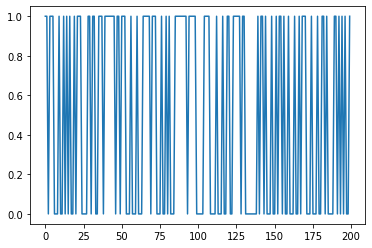

In [12]:
import matplotlib.pylab as plt
plt.plot(leaked_data[:200])
plt.show()

Do you think we'll be able to get something useful out of this? Let's attack it to find out.

## 3. AES Guesser

The attack is pretty simple. Let's just use our model of the device (we know what the encryption does after all, just not the secret key). And we'll feed in the observed data for each possible value of the key. And then we can observe how many (if any) of the keys result in the observation and simulation matching each other. If the observation and simulation match, this suggets our simulation is running in the same "setup" as the implementation we are attacking!

First, build a function to count the number of elements in a list that match between two lists (that is - same value of the element at the same list index). An easy way is to just iterate through the number of elements in the list and count the number that are the same. Fill in the following - there is already some bounds checking code to get you started.

### 3.1 `num_same()`

In [13]:
def num_same(a, b):

    if len(a) != len(b):
        raise ValueError("Arrays must be same length!")

    if max(a) != max(b):
        raise ValueError("Arrays max() should be the same!")
    
    #Count how many list items match up
    same = 0
    for i in range(len(a)):
        if a[i] == b[i]:
            same += 1
    return same

In [14]:
#Simple test vectors - if you get the check-mark printed all OK.
assert(num_same([0,1,0,1,1,1,1,0], [0,1,0,1,1,1,1,0]) == 8)
assert(num_same([1,1,1,0,0,0,0,0], [0,1,0,1,1,1,1,0]) == 2)
assert(num_same([1, 0], [0, 1]) == 0)
print("✔️ OK to continue!")

✔️ OK to continue!


The next block is the most important. You'll need to "apply" the leakage function - that is for each known input byte, pass it through the `aes_internal(input_data, key_guess)` function. The value of `key_guess` is just integers in `[0x00, 0x01,...,0xFF]` - aka every possible value of the key byte. We'll compare the number of matching bits between our observed (leaked) data bit and the hypothetical data bit.

### 3.2 Guessing Loop

In [15]:
for guess in range(0, 256):   
    
    #Get a hypothetical leakage list - use aes_internal(guess, input_byte) and mask off to only get value of lowest bit
    hypothetical_leakage = [aes_internal(key=guess, inputdata=input_byte) for input_byte in input_data]
    hypothetical_leakage = [get_bit_leaked_data(a, bitshift=random_select) for a in hypothetical_leakage]
    #Use our function
    same_count = num_same(hypothetical_leakage, leaked_data)   
    
    #Print for debug
    print("Guess {:02X}: {:4d} bits same".format(guess, same_count))

Guess 00:  508 bits same
Guess 01:  500 bits same
Guess 02:  551 bits same
Guess 03:  490 bits same
Guess 04:  472 bits same
Guess 05:  491 bits same
Guess 06:  472 bits same
Guess 07:  488 bits same
Guess 08:  481 bits same
Guess 09:  545 bits same
Guess 0A:  552 bits same
Guess 0B:  472 bits same
Guess 0C:  524 bits same
Guess 0D:  555 bits same
Guess 0E:  575 bits same
Guess 0F:  512 bits same
Guess 10:  445 bits same
Guess 11:  434 bits same
Guess 12:  446 bits same
Guess 13:  453 bits same
Guess 14:  512 bits same
Guess 15:  476 bits same
Guess 16:  486 bits same
Guess 17:  522 bits same
Guess 18:  517 bits same
Guess 19:  509 bits same
Guess 1A:  439 bits same
Guess 1B:  468 bits same
Guess 1C:  509 bits same
Guess 1D:  479 bits same
Guess 1E:  486 bits same
Guess 1F:  495 bits same
Guess 20:  473 bits same
Guess 21:  506 bits same
Guess 22:  492 bits same
Guess 23:  525 bits same
Guess 24:  537 bits same
Guess 25:  527 bits same
Guess 26:  443 bits same
Guess 27:  433 bits same


If your key guess is wrong, about half of the guesses should be wrong. Looking through the list, you'll see that most of the "bits same" numbers will be around 500. But scroll down to the correct key value (should be `0xEF` if you haven't changed it earlier). With any luck, that number should be fully correct - 1000 matching bits. This is only possible if the internal "secret key" byte matches the observed key.

### 3.3 `argsort` background

Now a handy thing to do will be to sort based on the values by number of correct bits so we don't have to look through that list. An easy way to do this is with `numpy.argsort` - this returns the indicies that would sort the list. To start small, take the following for example:

In [16]:
import numpy as np

count_list = [2, 7, 24, 4, 5]

np.argsort(count_list)

array([0, 3, 4, 1, 2])

This should return `[0, 3, 4, 1, 2]` - you can cast the above to `list()` type if you want to get rid of the `array()` type around it.

Inspecting the above, notice that this is the position of each from lowest to highest. We can reverse this to give us a highest to lowest sort instead:

In [17]:
import numpy as np

count_list = [2, 7, 24, 4, 5]

np.argsort(count_list)[::-1]

array([2, 1, 4, 3, 0])

Taking your previous code, simply make a new list which contains the number of elements which are the same, where the list index is the *key guess*. As a rough outline, see the following (you'll need to add back in your hypothetical code):

### 3.4 Guessing loop with sort

In [18]:
import numpy as np

guess_list = [0] * 256
for guess in range(0, 256):   
    
    #Get a hypothetical leakage list - use aes_internal(guess, input_byte) and mask off to only get value of lowest bit
    hypothetical_leakage = [aes_internal(key=guess, inputdata=input_byte) for input_byte in input_data]
    hypothetical_leakage = [get_bit_leaked_data(a, bitshift=random_select) for a in hypothetical_leakage]
    #Use our function
    same_count = num_same(hypothetical_leakage, leaked_data)   
    
    #Track the number of correct bits
    guess_list[guess] = same_count

#Use np.argsort to generate a list of indicies from low to high, then [::-1] to reverse the list to get high to low.
sorted_list = np.argsort(guess_list)[::-1]

#Print top 5 only
for guess in sorted_list[0:5]:
        print("Key Guess {:02X} = {:4d} matches".format(guess, guess_list[guess]))

Key Guess EF = 1000 matches
Key Guess 3A =  581 matches
Key Guess BF =  577 matches
Key Guess 0E =  575 matches
Key Guess 53 =  574 matches


In this case we know that bit '0' was the leakage. What if we didn't know that? Imagine putting our needle down onto the internal bus, but we aren't sure what bit we touched.

Luckily we can easily test that. To do so, we'll need to adjust our leakage function to take in a bit number that is leaking. First, define a function which returns the value of a bit being 1 or 0:

### 3.5 `get_bit()`

In [19]:
def get_bit(data, bit):
    if data & (1<<bit):
        return 1
    else:
        return 0

In [20]:
assert(get_bit(0xAA, 7) == 1)
assert(get_bit(0xAA, 0) == 0)
assert(get_bit(0x00, 7) == 0)
print("✔️ OK to continue!")

✔️ OK to continue!


Now let's make a slightly fancier leakage function with it:

In [21]:
def aes_leakage_guess(keyguess, inputdata, bit):
    return get_bit(aes_internal(inputdata, keyguess), bit)

In [22]:
assert(aes_leakage_guess(0xAB, 0x22, 4) == 0)
assert(aes_leakage_guess(0xAB, 0x22, 3) == 0)
assert(aes_leakage_guess(0xAB, 0x22, 2) == 1)
assert(aes_leakage_guess(0xAB, 0x22, 1) == 1)
assert(aes_leakage_guess(0xAB, 0x22, 0) == 1)
print("✔️ OK to continue!")

✔️ OK to continue!


Finally, finish off this loop by adding your leakage function into it. Running the loop should print results for each bit option - hopefully you see that only the matching bit shows the full number of matches. If you want to try a different leaky bit, you'll then need to go back up to the actual secret observation to make the leak happen from a different bit. But you can see the following code makes no assumptions about 'bit 0' being the leaky one - it will work with any other bit leaking now.

### 3.6 Bitwise Guessing Loop

In [23]:
for bit_guess in range(0, 8):
    guess_list = [0] * 256
    print("Checking bit {:d}".format(bit_guess))
    for guess in range(0, 256):

        #Get a hypothetical leakage for guessed bit (ensure returns 1/0 only)
        #Use bit_guess as the bit number, guess as the key guess, and data from input_data
        hypothetical_leakage = [aes_leakage_guess(keyguess=guess, inputdata=input_byte, bit=bit_guess) for input_byte in input_data]

        #Use our function
        same_count = num_same(hypothetical_leakage, leaked_data)   

        #Track the number of correct bits
        guess_list[guess] = same_count

    sorted_list = np.argsort(guess_list)[::-1]

    #Print top 5 only
    for guess in sorted_list[0:5]:
            print("Key Guess {:02X} = {:04d} matches".format(guess, guess_list[guess]))

Checking bit 0
Key Guess 5C = 0581 matches
Key Guess D6 = 0580 matches
Key Guess D9 = 0579 matches
Key Guess 53 = 0573 matches
Key Guess 8B = 0570 matches
Checking bit 1
Key Guess 6D = 0577 matches
Key Guess 51 = 0576 matches
Key Guess 89 = 0575 matches
Key Guess CE = 0569 matches
Key Guess 14 = 0569 matches
Checking bit 2
Key Guess 2A = 0595 matches
Key Guess DD = 0576 matches
Key Guess 3F = 0573 matches
Key Guess 29 = 0570 matches
Key Guess 04 = 0569 matches
Checking bit 3
Key Guess AC = 0595 matches
Key Guess 37 = 0579 matches
Key Guess EB = 0575 matches
Key Guess 01 = 0574 matches
Key Guess 73 = 0573 matches
Checking bit 4
Key Guess 95 = 0603 matches
Key Guess 9E = 0584 matches
Key Guess A6 = 0582 matches
Key Guess 72 = 0566 matches
Key Guess 63 = 0566 matches
Checking bit 5
Key Guess CB = 0578 matches
Key Guess 97 = 0572 matches
Key Guess 72 = 0570 matches
Key Guess E4 = 0569 matches
Key Guess 61 = 0568 matches
Checking bit 6
Key Guess EF = 1000 matches
Key Guess 3A = 0581 matches

🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳
Congrats - you did it!!!!

This all assumed you get some way to observe the value of the bit - in our next act, we'll see how power analysis gives us the ability to observe a given bit.

## 4. Bonus: Adding Noise and Plotting Success Rates

Are you not satisified by your attack? Why not see what happens when you add some noise into the equation?

Remember this simple leakage from earlier:

```python
    leaked_data = [(aes_secret(a) & 0x01) for a in input_data]
```

This relied on another function `aes_secret()`, which we could define as such to return incorrect responses sometimes:

```python
    import random
    def aes_secret(inputdata):
        secret_key = 0xEF
        correct = aes_internal(secret_key, inputdata)
        
        if random.randint(0, 100) < 10:
            return correct
        else
            return 0 
        
```

What happens now? While it should take more guesses to get the correct byte out. In fact, we could even make a plot of the percentage of returned wrong results, and how many observations it took to get the correct answer.

The end result should look something like this:

<img src="img/traces_wrong.png" alt="Noisy Observations" width="450"/>

Give it a try. If you get stuck of course you can check out the solution lab too - this one is a little trickier, we really threw you in the deep end here. Don't feel bad looking for a ⛑️.

You'll notice the data is pretty noisy too. You might want to average several attempts. And you can also set the leakage to be a tiny amount of information only - it will require more observations to recover the data, but the data is fundamentally there still.

In [24]:
import random

def aes_secret_noisy(inputdata, num_correct):
    secret_key = 0xEF
    correct = aes_internal(inputdata=inputdata, key=secret_key)

    if random.randint(0, 100) <= num_correct:
        return correct
    else:
        return 0
def num_same(a, b):

    if len(a) != len(b):
        raise ValueError("Arrays must be same length!")
    
    #Count how many list items match up
    same = 0
    for i in range(len(a)):
        if a[i] == b[i]:
            same += 1
    return same
#set the percentage to correct observations
chances_to_try = range(20, 105, 5)
traces_used = []
shift_bit = 0x00
for chance_correct in chances_to_try:
    leaked_data = [aes_secret_noisy(a, chance_correct) for a in input_data]
    leaked_data = [get_bit_leaked_data(x, shift_bit) for x in leaked_data]
    #Try for number of traces
    for traces in range(1, len(input_data), 1):
        guess_list = [0] * 256

        for guess in range(0, 256):
            hypothetical_leakage = [aes_internal(key=guess, inputdata=input_byte) for input_byte in input_data[0:traces]]
            hypothetical_leakage = [get_bit_leaked_data(x, shift_bit) for x in hypothetical_leakage]
            same_count = num_same(hypothetical_leakage, leaked_data[0:traces])

            guess_list[guess] = same_count
        sorted_list = np.argsort(guess_list)[::-1]

        if sorted_list[0] == 0xEF:
            print("Found key at %d %% correct data with %d encryptions"%(chance_correct, traces))
            print(guess_list[sorted_list[0]])
            traces_used.append(traces)
            break
    if sorted_list[0] != 0xEF:
        raise ValueError("Failed to find answer for %d %% - need more traces"%(chance_correct))


Found key at 20 % correct data with 121 encryptions
76
Found key at 25 % correct data with 44 encryptions
30
Found key at 30 % correct data with 28 encryptions
20
Found key at 35 % correct data with 83 encryptions
55
Found key at 40 % correct data with 62 encryptions
43
Found key at 45 % correct data with 22 encryptions
17
Found key at 50 % correct data with 42 encryptions
32
Found key at 55 % correct data with 4 encryptions
4
Found key at 60 % correct data with 4 encryptions
4
Found key at 65 % correct data with 4 encryptions
4
Found key at 70 % correct data with 20 encryptions
16
Found key at 75 % correct data with 19 encryptions
15
Found key at 80 % correct data with 4 encryptions
4
Found key at 85 % correct data with 17 encryptions
15
Found key at 90 % correct data with 4 encryptions
4
Found key at 95 % correct data with 4 encryptions
4
Found key at 100 % correct data with 4 encryptions
4


Text(0, 0.5, 'Encryptions To Recover Key')

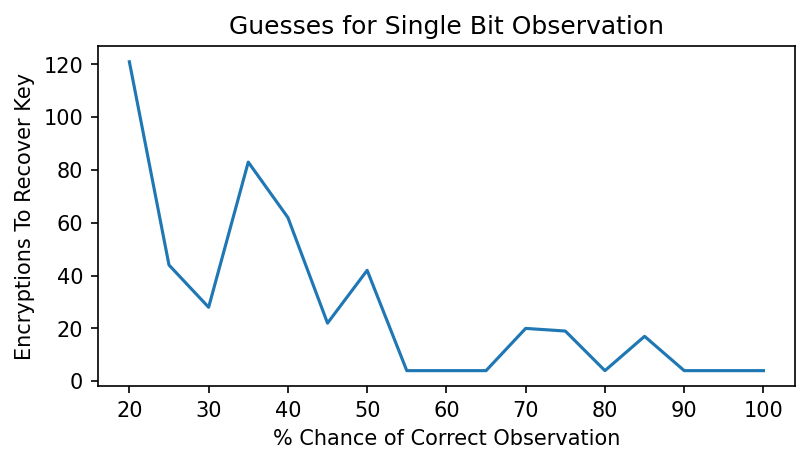

In [25]:
import matplotlib.pylab as plt

plt.figure(figsize=(6,3), dpi=150)
plt.plot(chances_to_try, traces_used)
plt.title('Guesses for Single Bit Observation')
plt.xlabel('% Chance of Correct Observation')
plt.ylabel('Encryptions To Recover Key')

---
<small>NO-FUN DISCLAIMER: This material is Copyright (C) NewAE Technology Inc., 2015-2020. ChipWhisperer is a trademark of NewAE Technology Inc., claimed in all jurisdictions, and registered in at least the United States of America, European Union, and Peoples Republic of China.

Tutorials derived from our open-source work must be released under the associated open-source license, and notice of the source must be *clearly displayed*. Only original copyright holders may license or authorize other distribution - while NewAE Technology Inc. holds the copyright for many tutorials, the github repository includes community contributions which we cannot license under special terms and **must** be maintained as an open-source release. Please contact us for special permissions (where possible).

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</small>